In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import graphviz
from torchview import draw_graph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

Dataset

In [2]:
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
NUM_CLASSES = 10

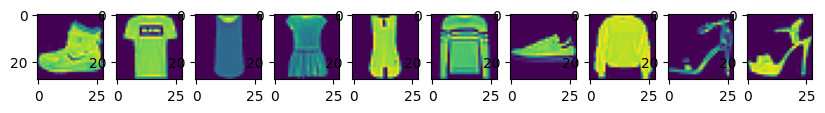

In [3]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_set[i][0].squeeze().numpy())

In [4]:
IMG_SIZE = 32
IMG_CH = 1
BATCH_SIZE = 128

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=data_transform)
data = torch.utils.data.ConcatDataset([train_set, test_set])
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)    

# U-Net
DownBlock Architecture

In [6]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(num_features=self.out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.batchnorm2d(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batchnorm2d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

In [7]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_1 = nn.ConvTranspose2d(in_channels=2 * self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(num_features=self.out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, skip):
        x = torch.cat((x, skip), dim=1)
        x = self.conv_1(x)
        x = self.batchnorm2d(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batchnorm2d(x)
        x = self.relu(x)
        return x

In [30]:
class UNet(nn.Module):
    def __init__(self, IMG_CH):
        super().__init__()
        down_channels = [16, 32, 64, 128]
        latent_image_size = IMG_SIZE // 2**(len(down_channels) - 1)
        
        # Down sampling
        self.down_0 = nn.Sequential(
            nn.Conv2d(IMG_CH, down_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(down_channels[0]),
            nn.ReLU()
        )  # 1x32x32 -> 16x32x32
        self.down_1 = DownBlock(in_channels=down_channels[0], out_channels=down_channels[1])    # 16x32x32 -> 32x16x16
        self.down_2 = DownBlock(in_channels=down_channels[1], out_channels=down_channels[2])    # 32x16x16 -> 64x8x8
        self.down_3 = DownBlock(in_channels=down_channels[2], out_channels=down_channels[3])   # 64x8x8 -> 128x4x4

        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU()) # 128x4x4 -> 2048
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(down_channels[-1] * latent_image_size * latent_image_size, down_channels[-2]), #2048 -> 128
            nn.ReLU(),
            nn.Linear(down_channels[-2], down_channels[-2]), #128 -> 128
            nn.ReLU(),   
            nn.Linear(down_channels[-2], down_channels[-1] * latent_image_size * latent_image_size), #128 -> 2048
            nn.ReLU()
        )

        # Up sampling
        up_channels = down_channels[::-1] # [128, 64, 32, 16]
        self.up_0 = nn.Sequential(
            nn.Unflatten(1, (up_channels[0], latent_image_size, latent_image_size)),  # 2048 -> 128x4x4  
            nn.Conv2d(up_channels[0], up_channels[0], kernel_size=3, padding=1),   # 128x4x4 -> 128x4x4
            nn.BatchNorm2d(up_channels[0]),
            nn.ReLU()
        )
        self.up_1 = UpBlock(in_channels=up_channels[0], out_channels=up_channels[1])   # 128x4x4 -> 64x8x8
        self.up_2 = UpBlock(in_channels=up_channels[1], out_channels=up_channels[2])   # 64x8x8 -> 32x16x16
        self.up_3 = UpBlock(in_channels=up_channels[2], out_channels=up_channels[3])    # 32x16x16 -> 16x32x32

        
        self.out = nn.Sequential(
            nn.Conv2d(up_channels[-1], up_channels[-1], kernel_size=3, padding=1),
            nn.BatchNorm2d(up_channels[-1]),
            nn.ReLU(),
            nn.Conv2d(up_channels[-1], IMG_CH, kernel_size=3, padding=1)
        )

    def forward(self, x):
        down_0 = self.down_0(x)
        down_1 = self.down_1(down_0)
        down_2 = self.down_2(down_1)
        down_3 = self.down_3(down_2)
        x = self.to_vec(down_3)
        x = self.embedding(x)
        x = self.up_0(x)
        x = self.up_1(x, down_3)
        x = self.up_2(x, down_2)
        x = self.up_3(x, down_1)
        x = self.out(x)
        return x

In [31]:
model = UNet(IMG_CH).to(device)
print('Parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Parameters:  952513



(process:30148): Pango-WARNING **: 16:13:31.341: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


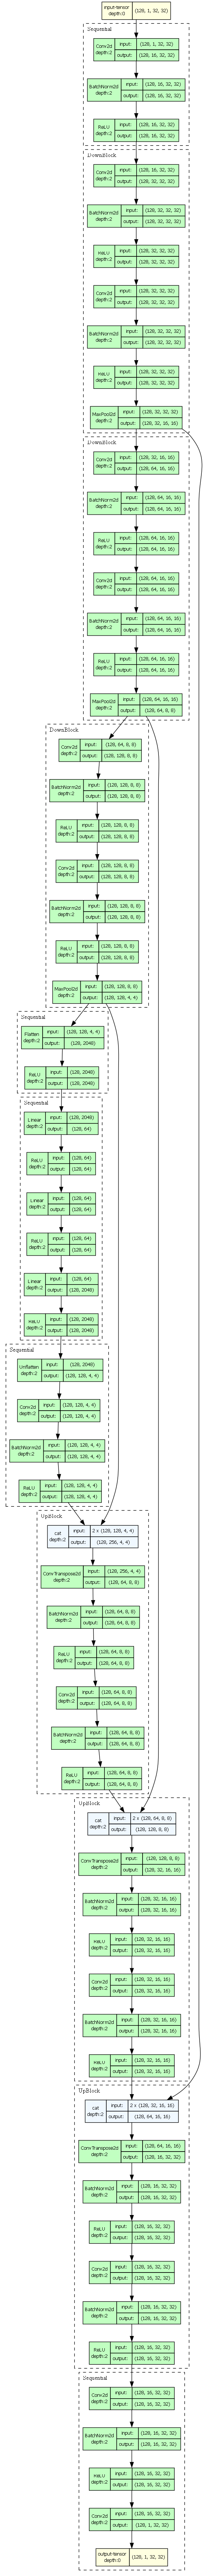

In [32]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, 
                         input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
                         device=device,
                         expand_nested=True)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

Noise addition

In [33]:
def add_noise(img, noise_level=0.5):
    noise = torch.randn_like(img)
    return (1 - noise_level) * img + noise_level * noise

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

Epoch: 0, Batch: 0, Loss: 0.8727685213088989


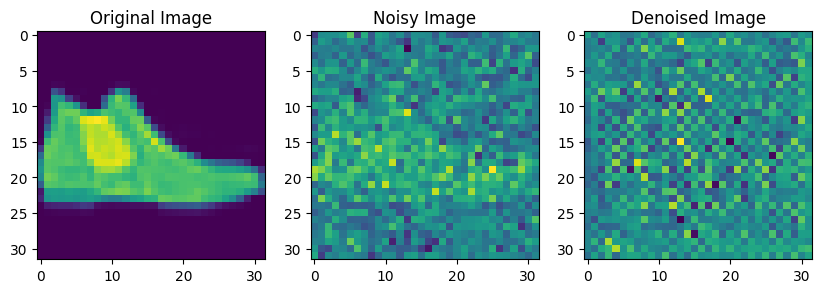

Epoch: 0, Batch: 100, Loss: 0.08929391205310822


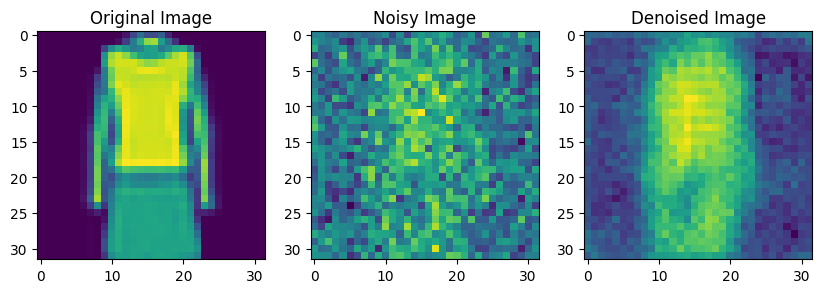

Epoch: 0, Batch: 200, Loss: 0.0630924254655838


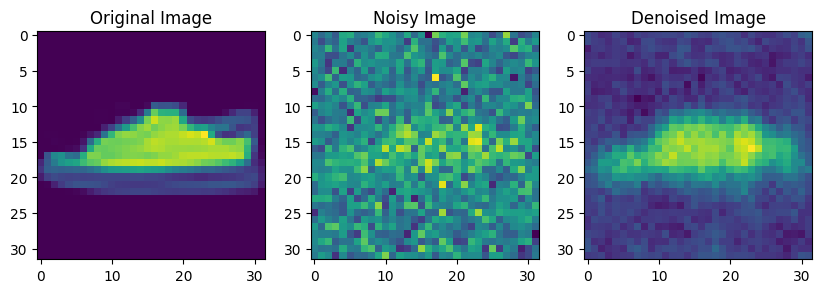

Epoch: 0, Batch: 300, Loss: 0.0525897778570652


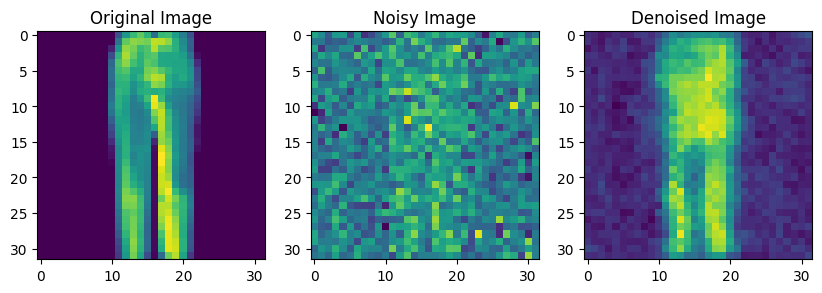

Epoch: 0, Batch: 400, Loss: 0.05046720802783966


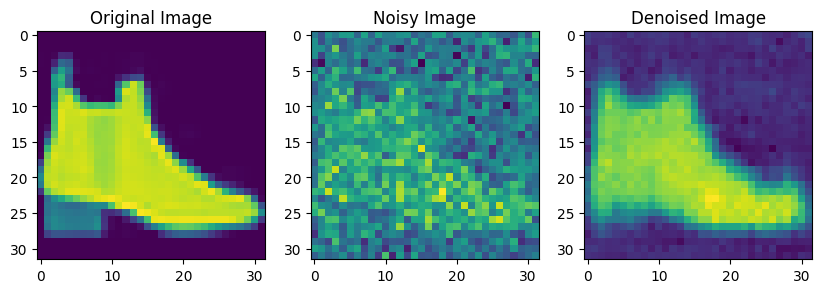

Epoch: 0, Batch: 500, Loss: 0.04341938719153404


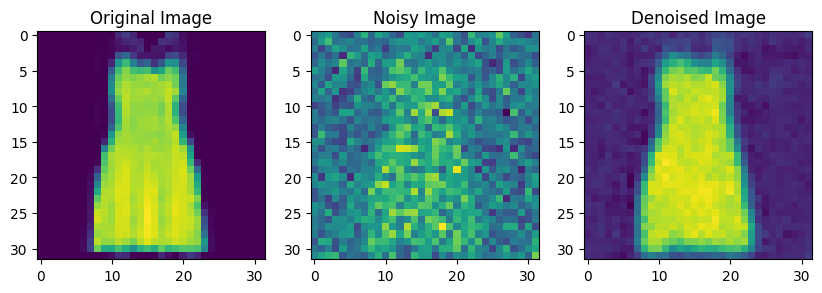

Epoch: 1, Batch: 0, Loss: 0.04240904375910759


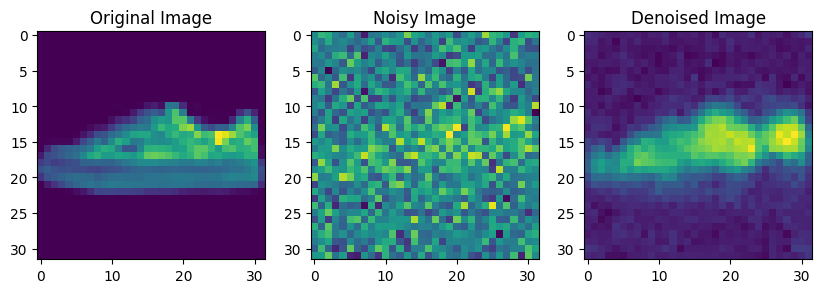

Epoch: 1, Batch: 100, Loss: 0.039632782340049744


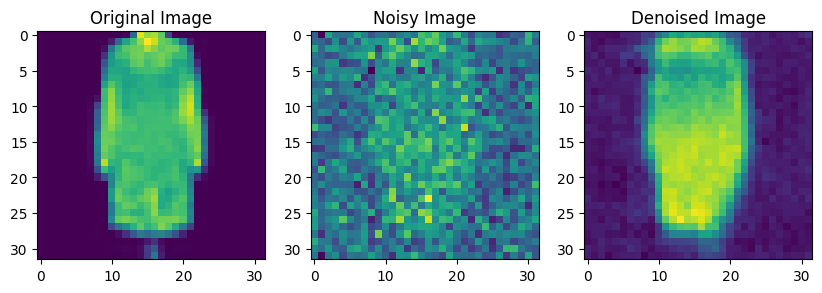

Epoch: 1, Batch: 200, Loss: 0.04185844585299492


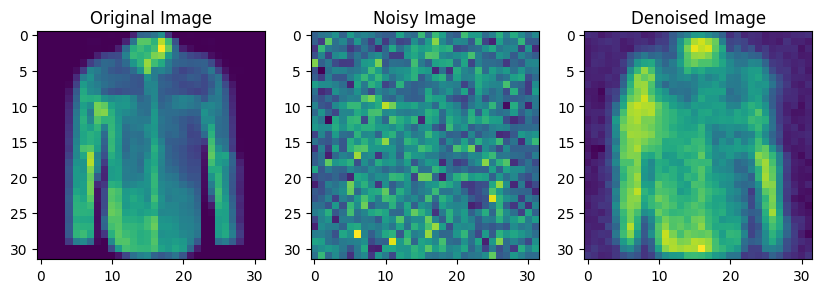

Epoch: 1, Batch: 300, Loss: 0.038208164274692535


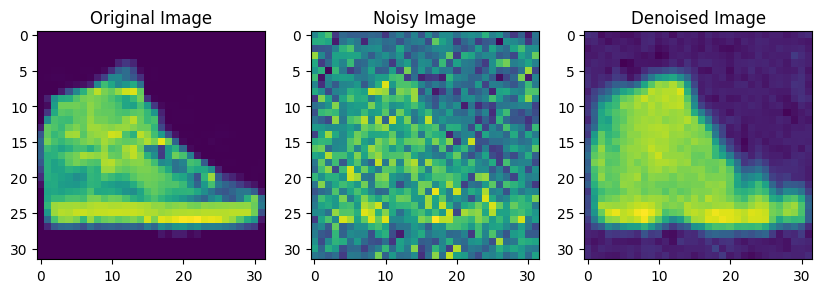

Epoch: 1, Batch: 400, Loss: 0.04034176096320152


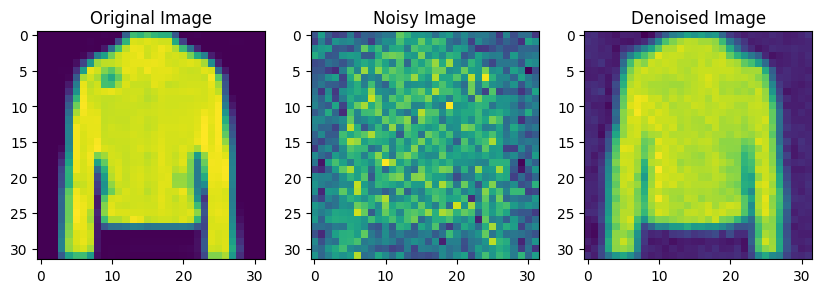

Epoch: 1, Batch: 500, Loss: 0.03767957165837288


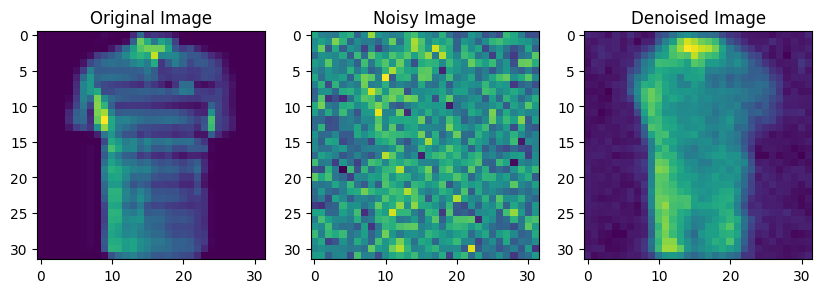

Epoch: 2, Batch: 0, Loss: 0.03561631962656975


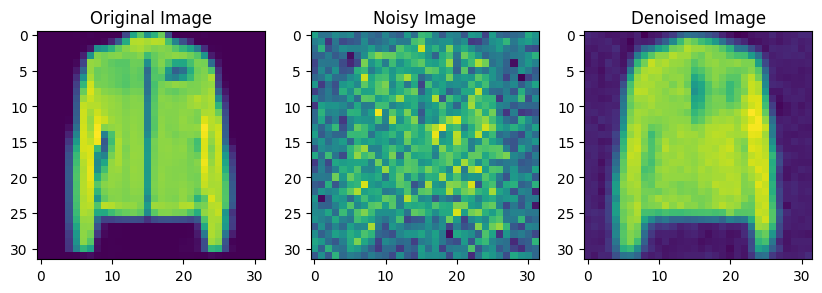

Epoch: 2, Batch: 100, Loss: 0.037697404623031616


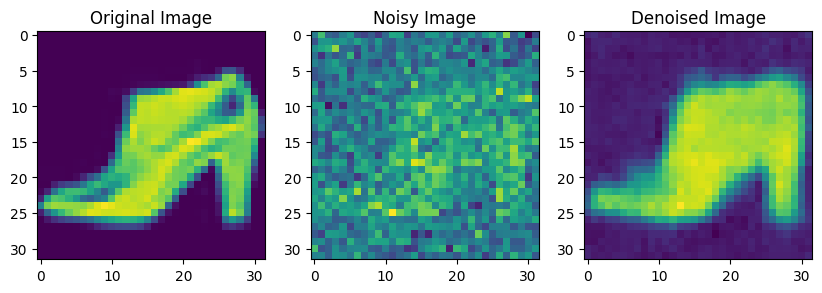

Epoch: 2, Batch: 200, Loss: 0.036578960716724396


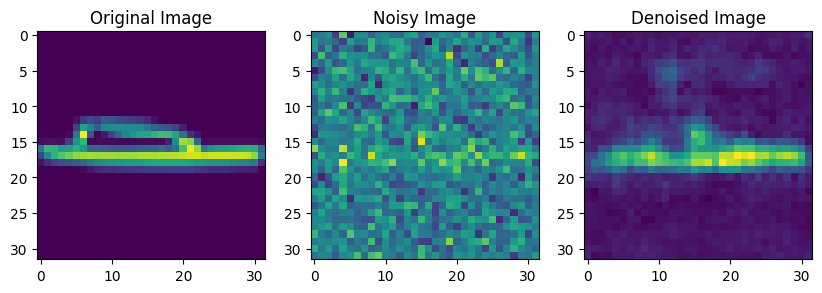

Epoch: 2, Batch: 300, Loss: 0.03673427924513817


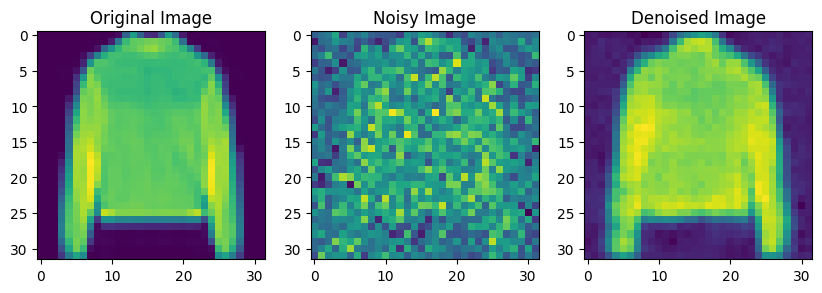

Epoch: 2, Batch: 400, Loss: 0.0358048751950264


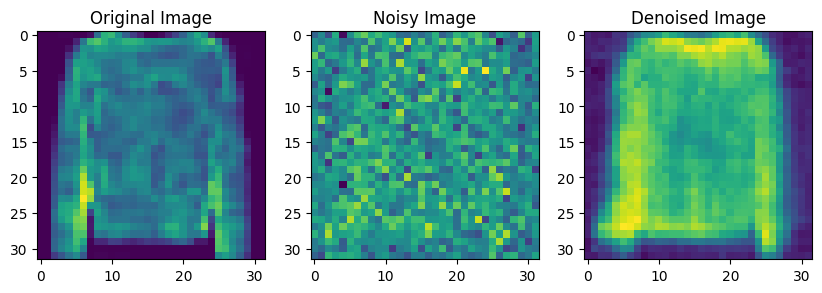

Epoch: 2, Batch: 500, Loss: 0.034563690423965454


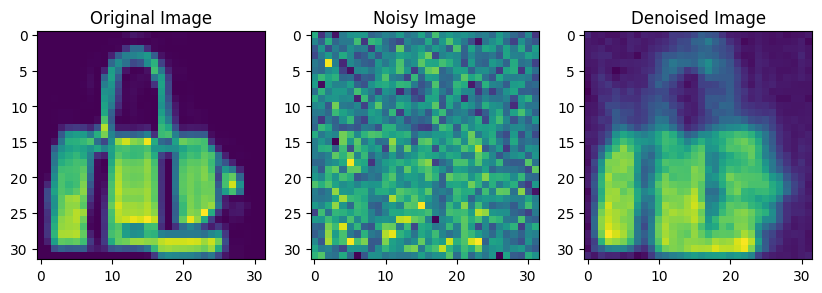

Epoch: 3, Batch: 0, Loss: 0.03387009724974632


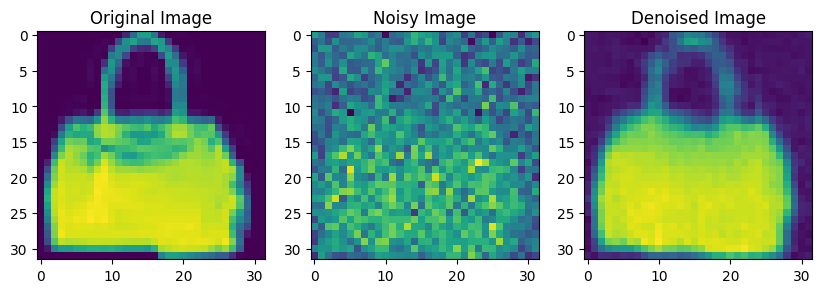

Epoch: 3, Batch: 100, Loss: 0.035237185657024384


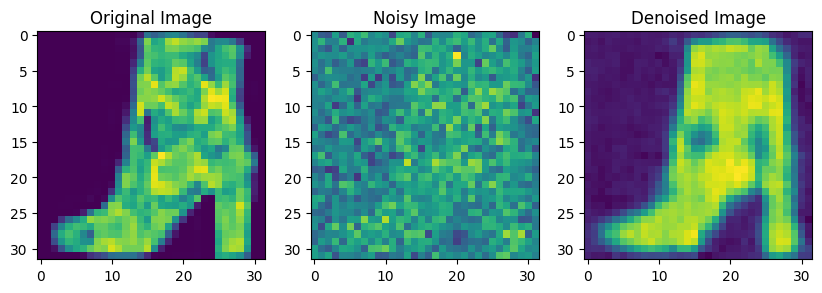

Epoch: 3, Batch: 200, Loss: 0.03623195365071297


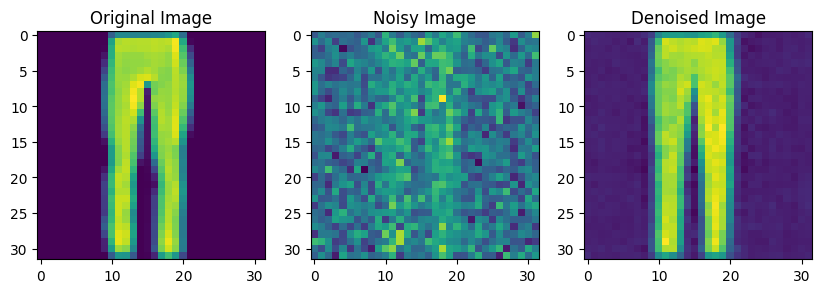

Epoch: 3, Batch: 300, Loss: 0.03412289917469025


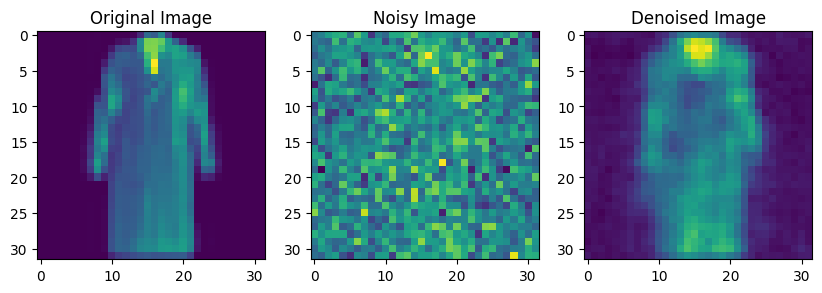

Epoch: 3, Batch: 400, Loss: 0.032583050429821014


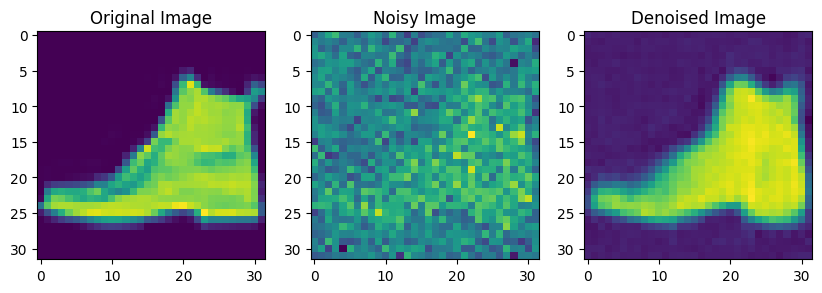

Epoch: 3, Batch: 500, Loss: 0.03191066160798073


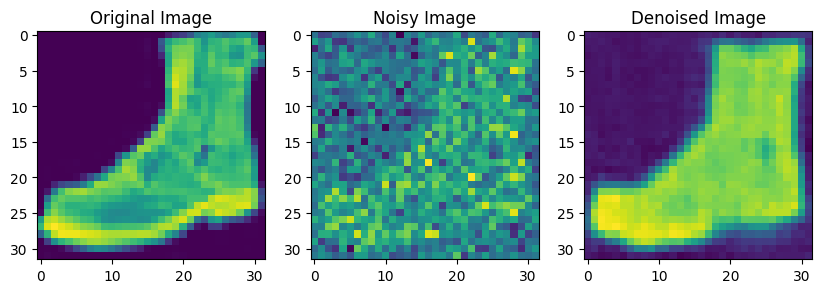

Epoch: 4, Batch: 0, Loss: 0.033000919967889786


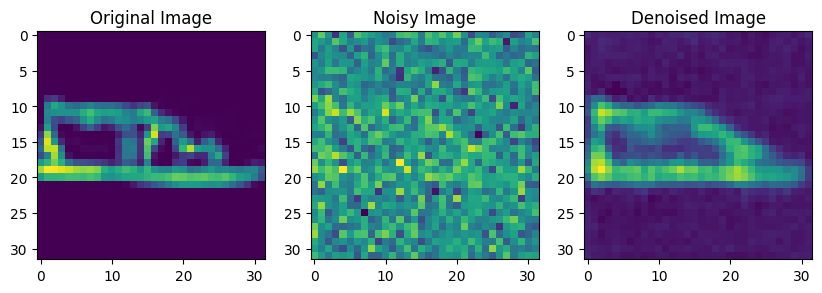

Epoch: 4, Batch: 100, Loss: 0.034838587045669556


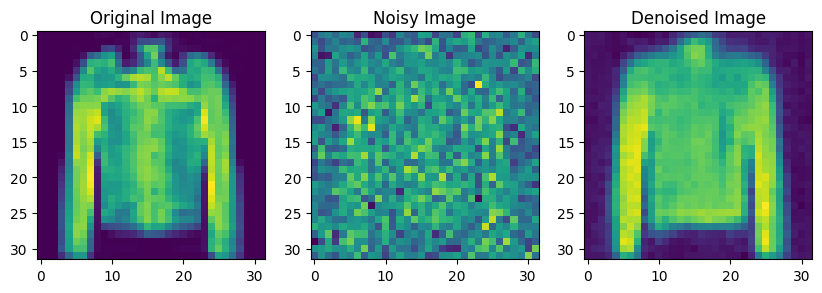

Epoch: 4, Batch: 200, Loss: 0.03179819509387016


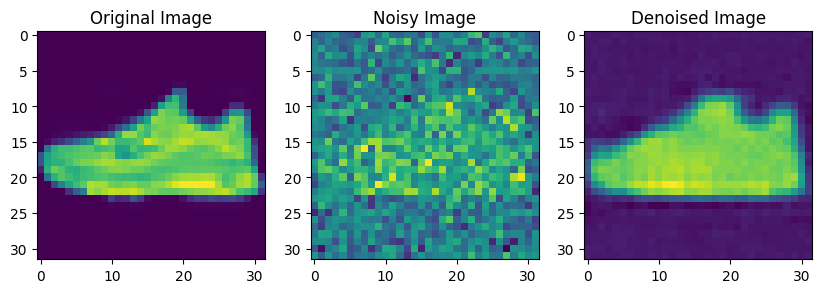

Epoch: 4, Batch: 300, Loss: 0.03383265435695648


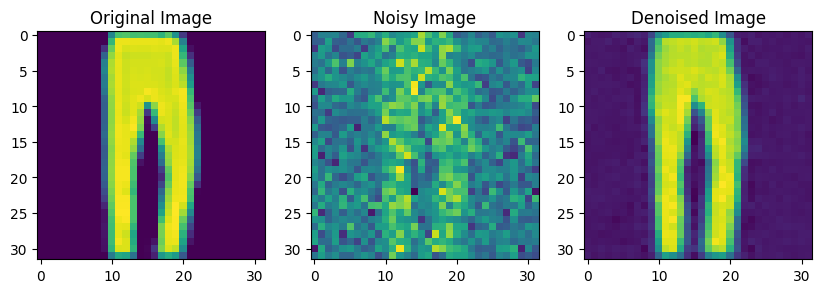

Epoch: 4, Batch: 400, Loss: 0.03234599158167839


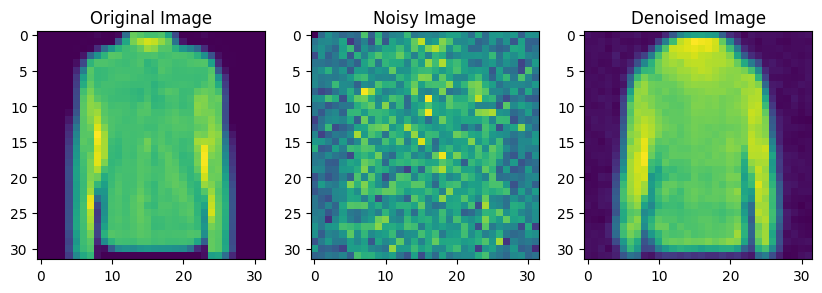

Epoch: 4, Batch: 500, Loss: 0.03333655744791031


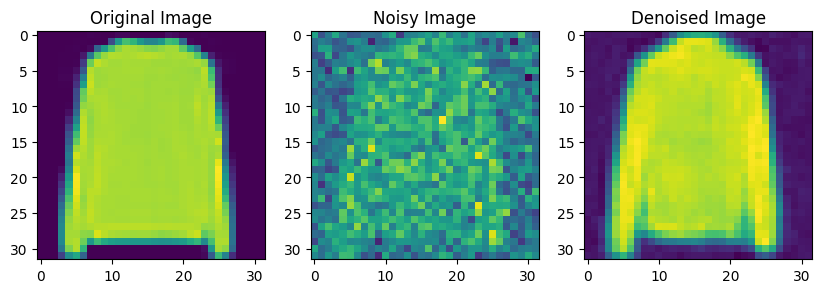

Epoch: 5, Batch: 0, Loss: 0.03247939050197601


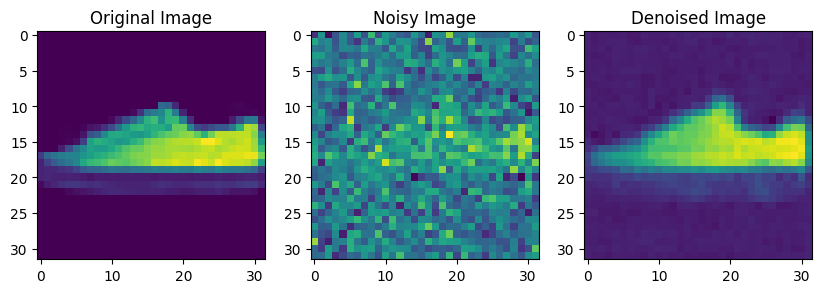

Epoch: 5, Batch: 100, Loss: 0.030167948454618454


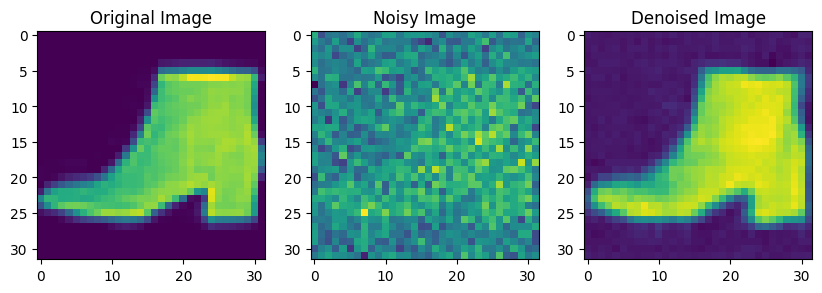

Epoch: 5, Batch: 200, Loss: 0.03378953039646149


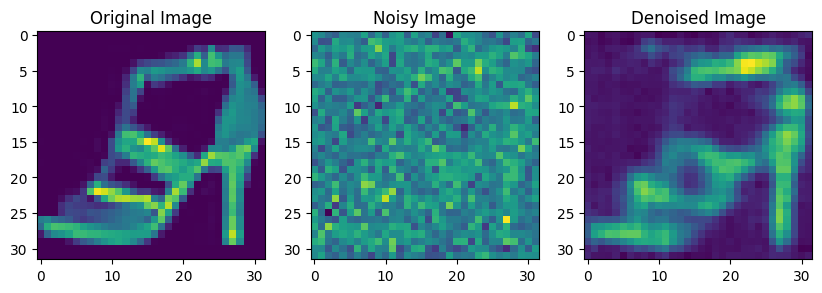

Epoch: 5, Batch: 300, Loss: 0.03326946496963501


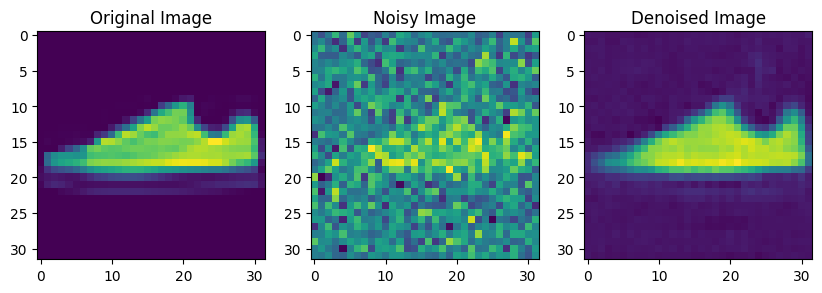

Epoch: 5, Batch: 400, Loss: 0.03304233402013779


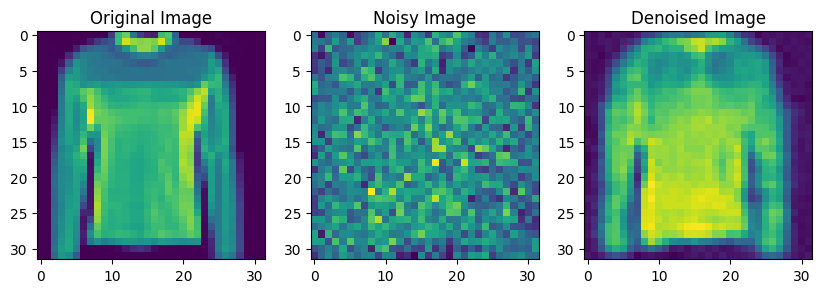

Epoch: 5, Batch: 500, Loss: 0.030478164553642273


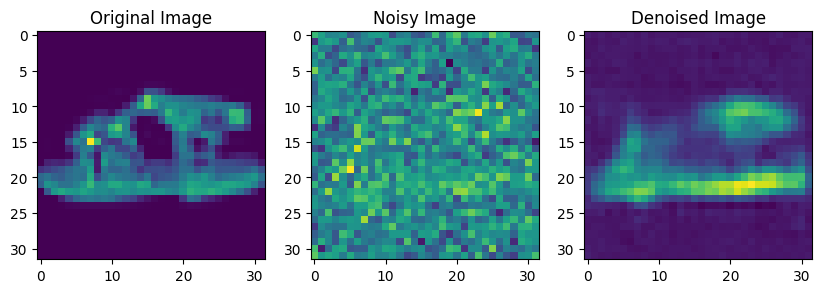

Epoch: 6, Batch: 0, Loss: 0.03302576392889023


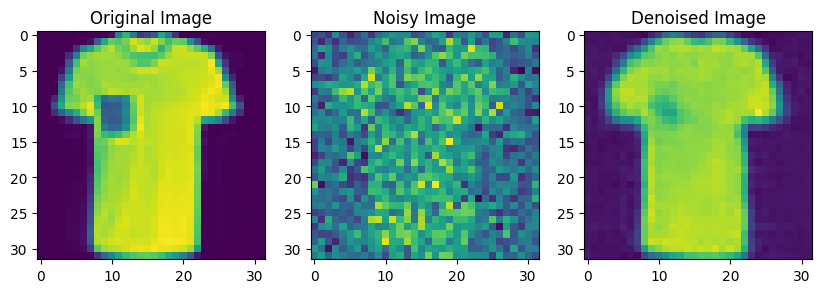

Epoch: 6, Batch: 100, Loss: 0.0316624715924263


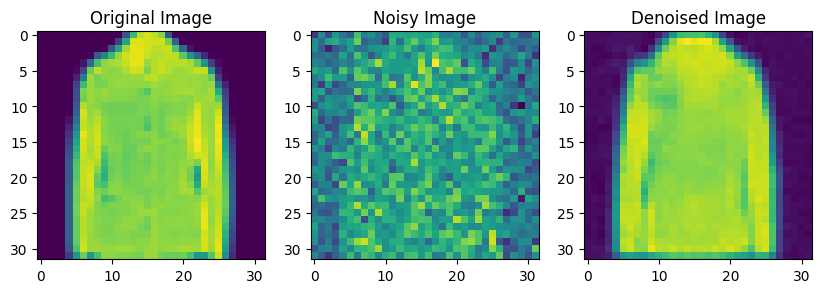

Epoch: 6, Batch: 200, Loss: 0.0336012989282608


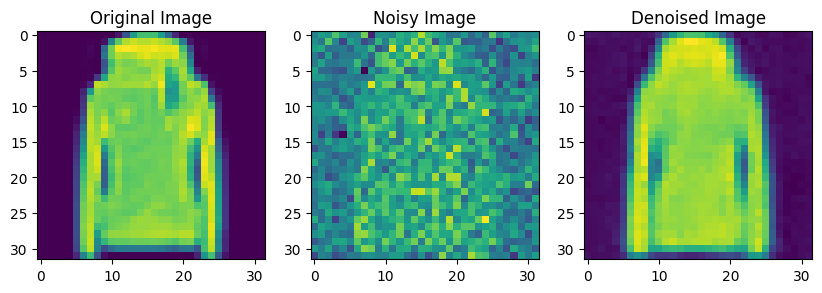

Epoch: 6, Batch: 300, Loss: 0.02984652854502201


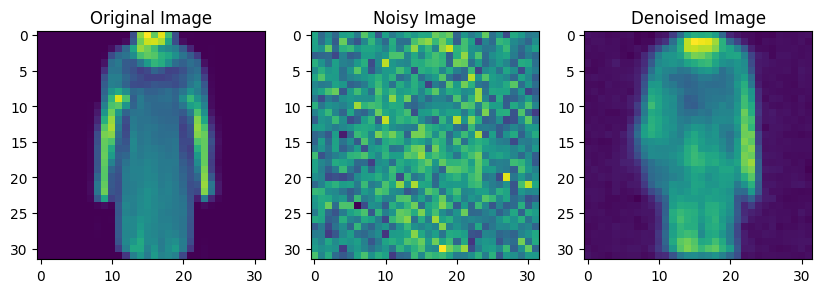

Epoch: 6, Batch: 400, Loss: 0.02980499342083931


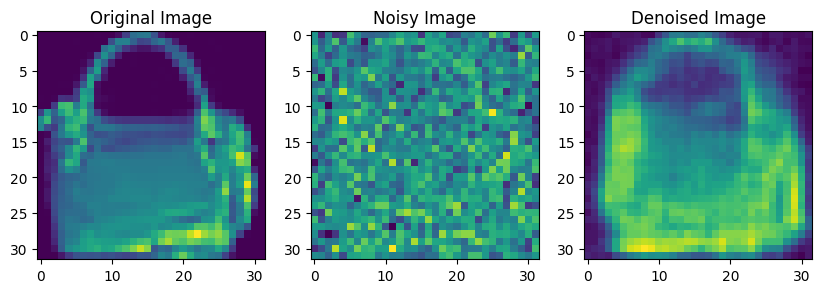

Epoch: 6, Batch: 500, Loss: 0.03110453486442566


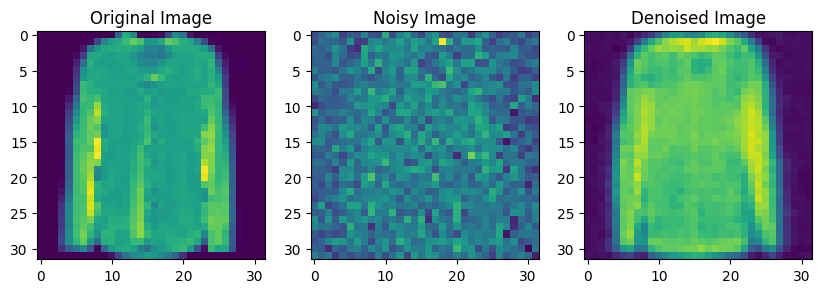

Epoch: 7, Batch: 0, Loss: 0.03235018998384476


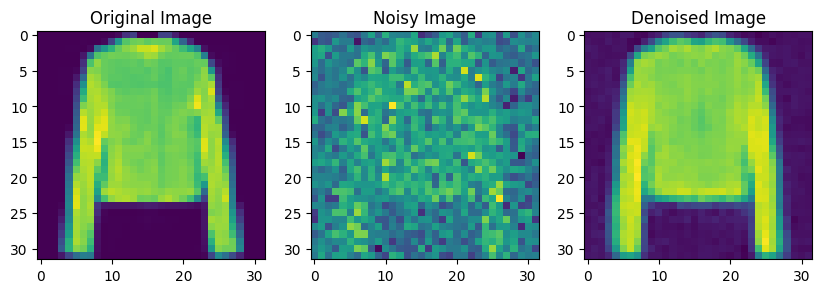

Epoch: 7, Batch: 100, Loss: 0.03043379634618759


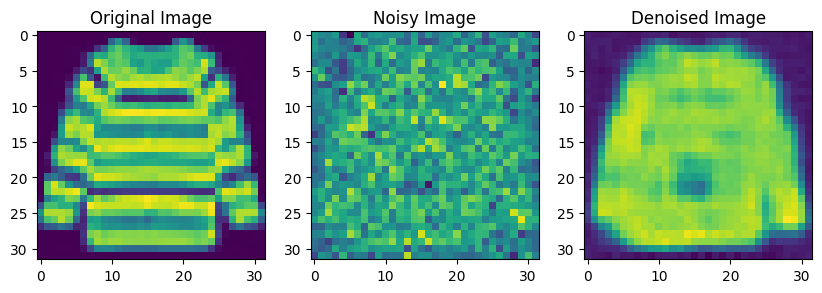

Epoch: 7, Batch: 200, Loss: 0.03065422549843788


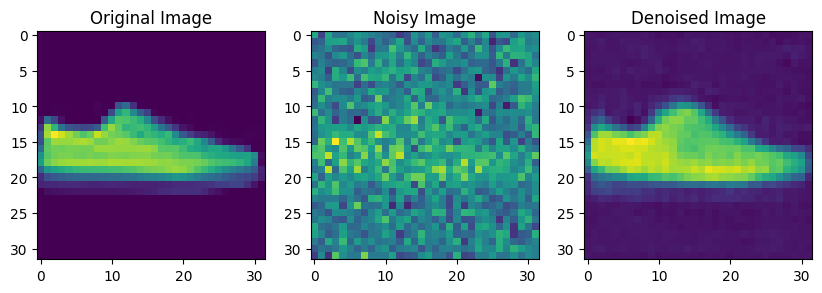

Epoch: 7, Batch: 300, Loss: 0.029223337769508362


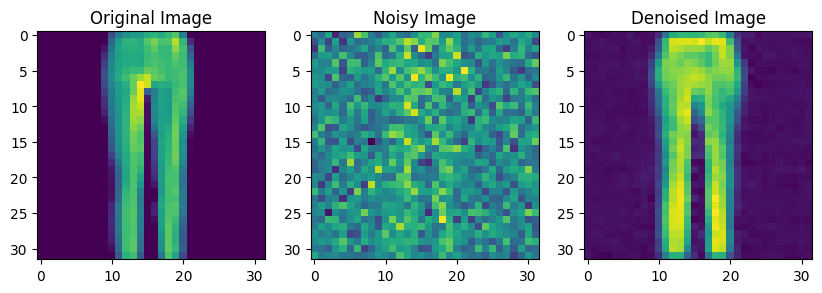

Epoch: 7, Batch: 400, Loss: 0.031775712966918945


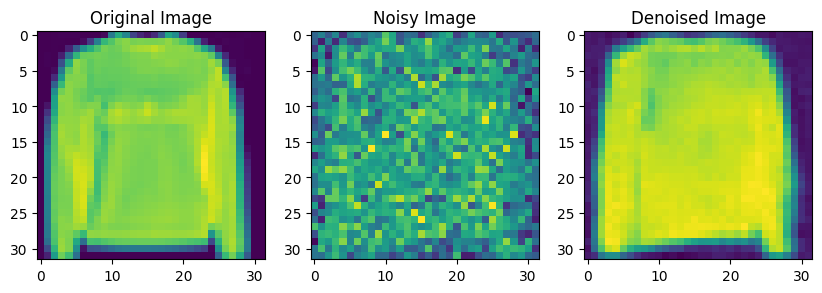

Epoch: 7, Batch: 500, Loss: 0.030641060322523117


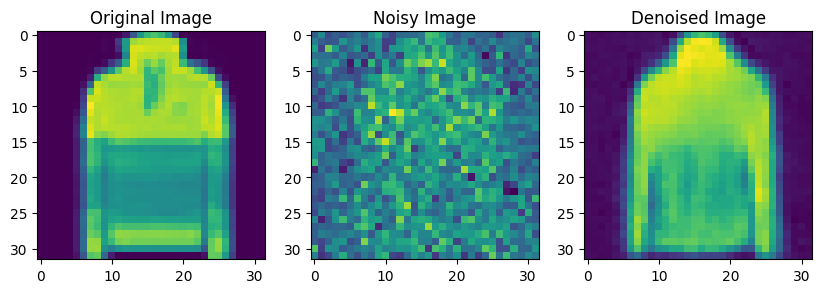

Epoch: 8, Batch: 0, Loss: 0.02913568913936615


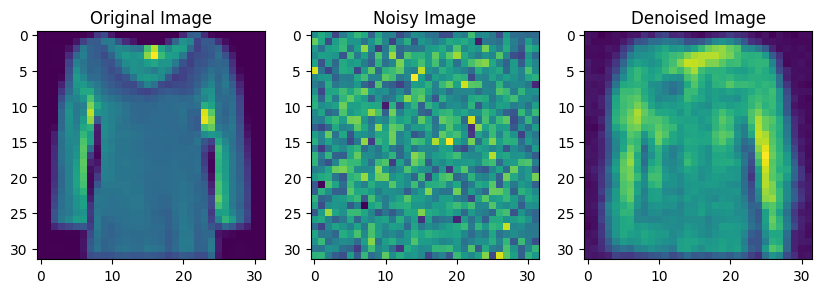

Epoch: 8, Batch: 100, Loss: 0.029942618682980537


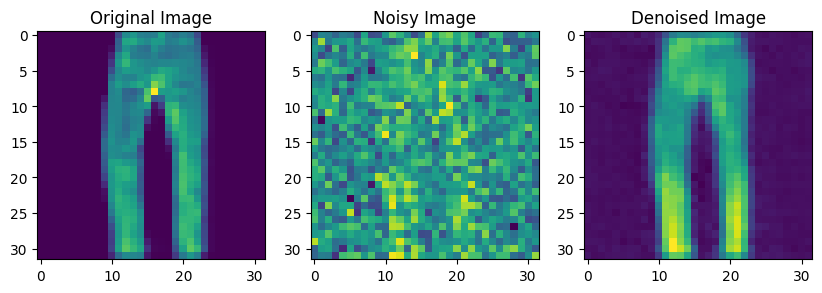

Epoch: 8, Batch: 200, Loss: 0.032260674983263016


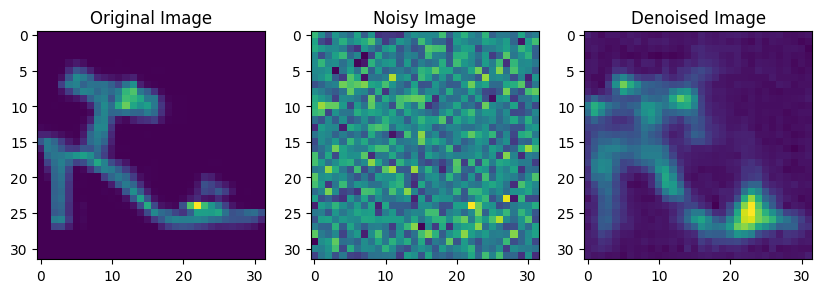

Epoch: 8, Batch: 300, Loss: 0.028441619127988815


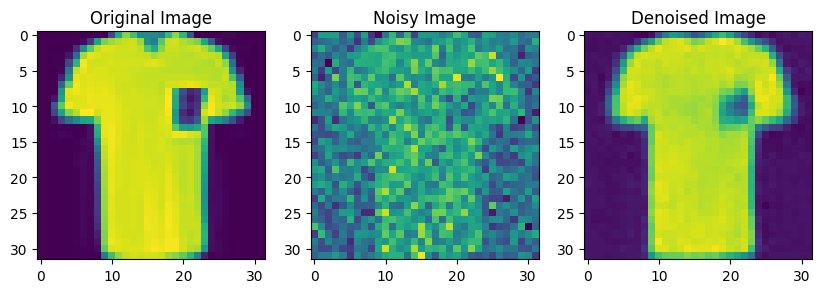

Epoch: 8, Batch: 400, Loss: 0.029908940196037292


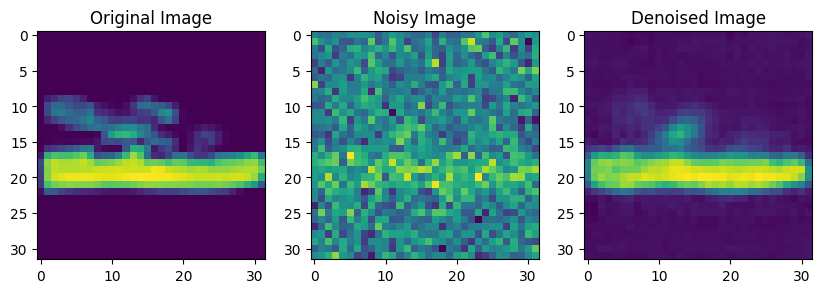

Epoch: 8, Batch: 500, Loss: 0.029875215142965317


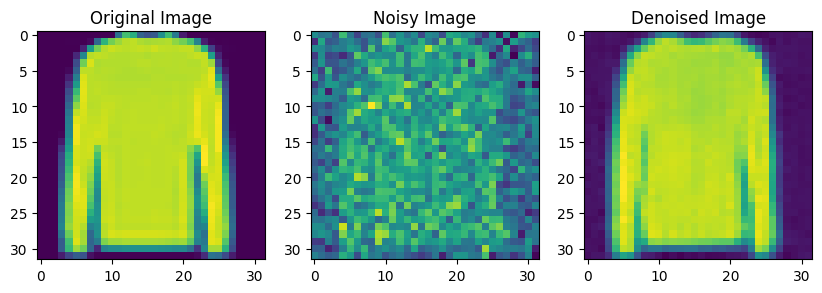

Epoch: 9, Batch: 0, Loss: 0.02961309254169464


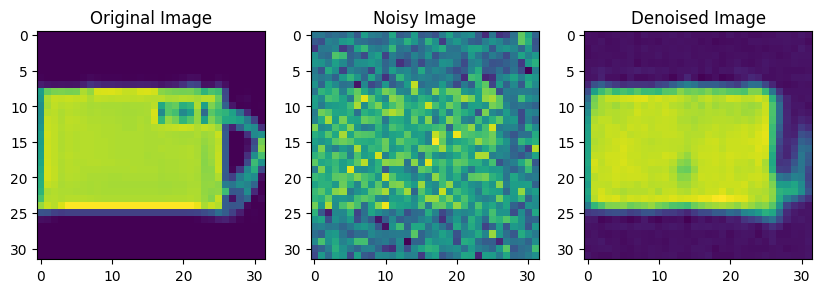

Epoch: 9, Batch: 100, Loss: 0.030158426612615585


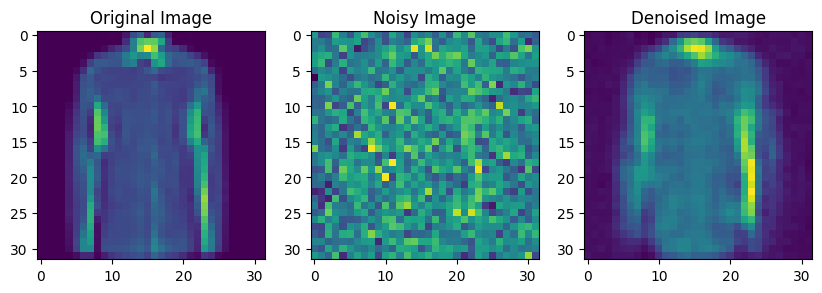

Epoch: 9, Batch: 200, Loss: 0.03144080564379692


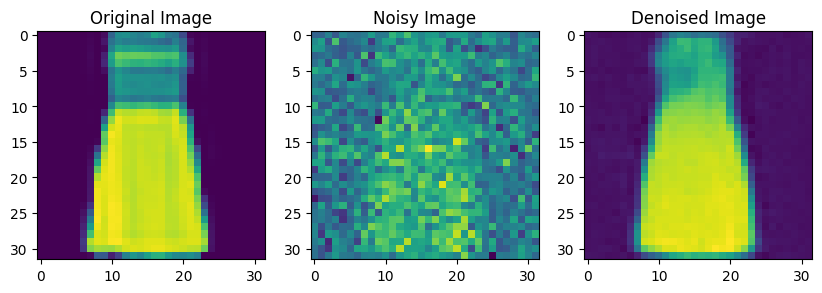

Epoch: 9, Batch: 300, Loss: 0.03000403568148613


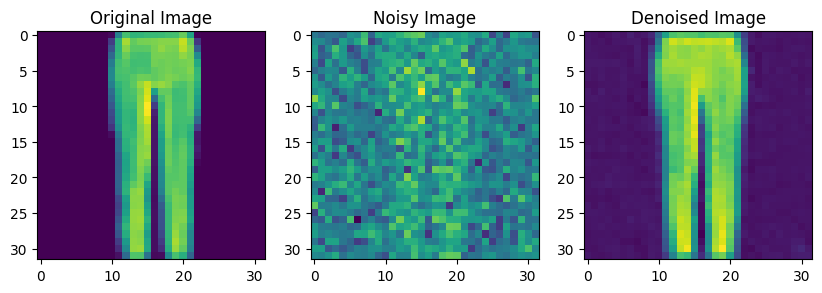

Epoch: 9, Batch: 400, Loss: 0.03176860511302948


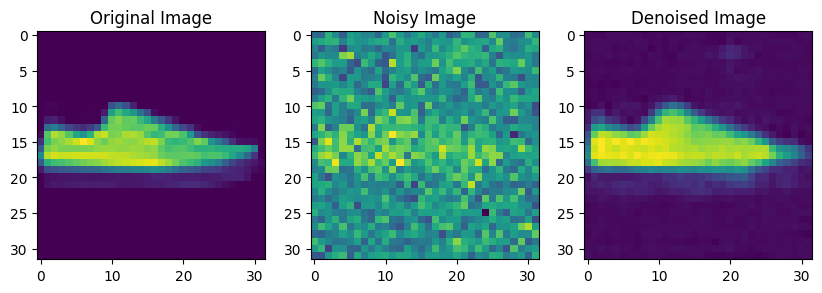

Epoch: 9, Batch: 500, Loss: 0.03155386075377464


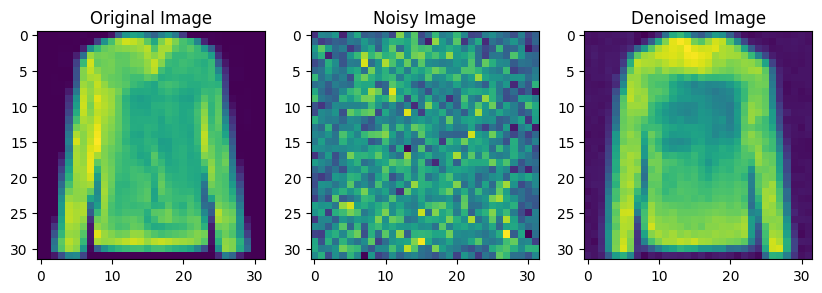

In [35]:
model.train()
for epoch in range(epochs):
    for i, (img, _) in enumerate(data_loader):
        img = img.to(device)
        noisy_img = add_noise(img).to(device)
        
        optimizer.zero_grad()
        output = model(noisy_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(img[0].squeeze().cpu().detach().numpy())
            plt.title("Original Image")
            plt.subplot(1, 3, 2)
            plt.imshow(noisy_img[0].squeeze().cpu().detach().numpy())
            plt.title("Noisy Image")
            plt.subplot(1, 3, 3)
            plt.imshow(output[0].squeeze().cpu().detach().numpy())
            plt.title("Denoised Image")
            plt.show()
    

Testing

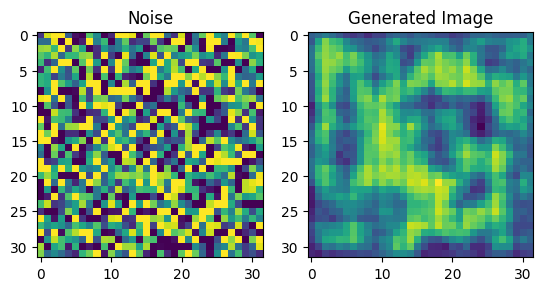

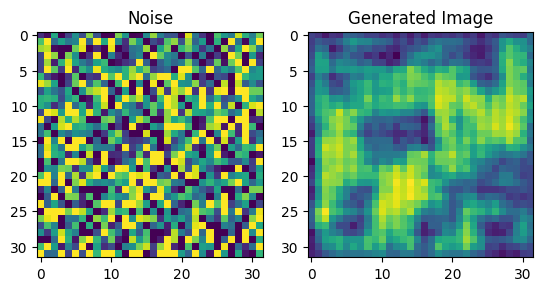

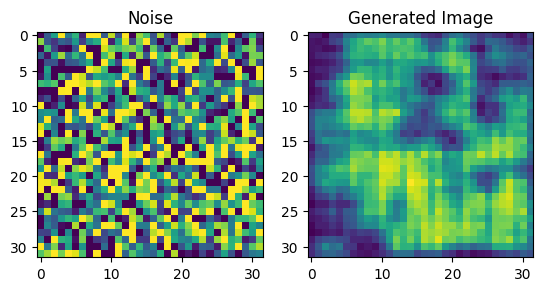

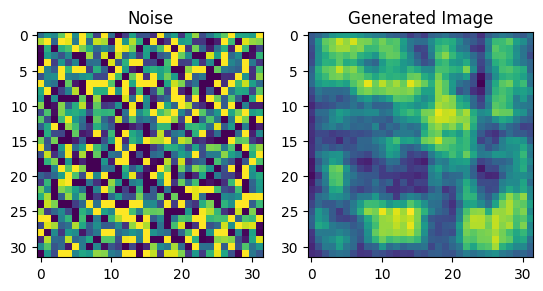

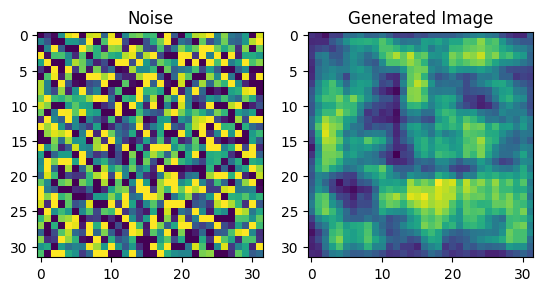

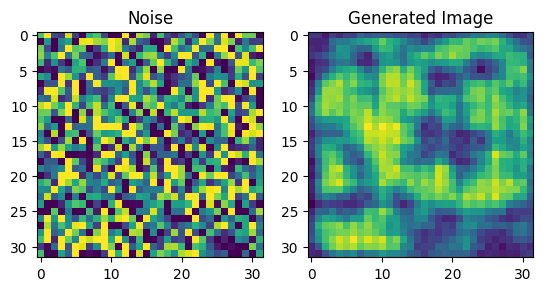

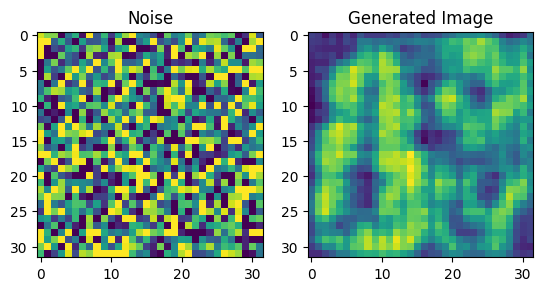

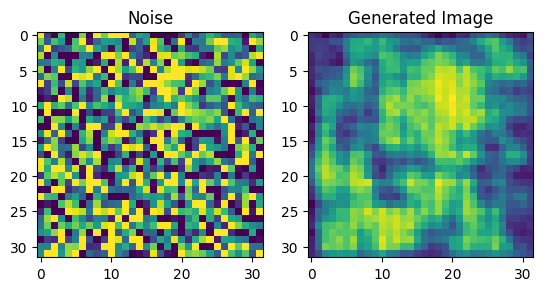

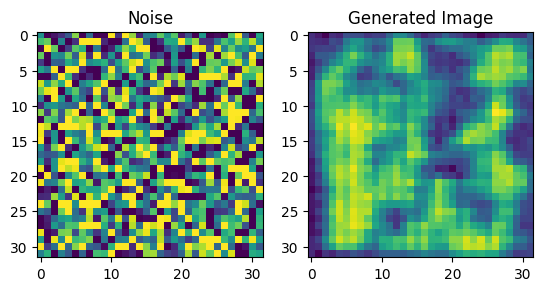

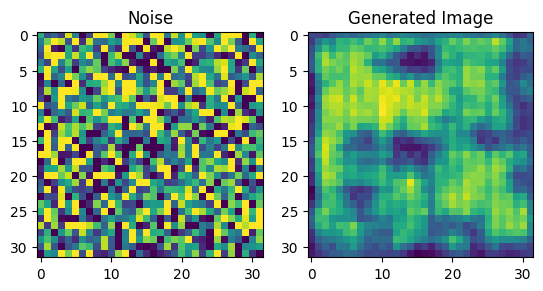

In [36]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))


model.eval()
for _ in range(10):
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)
    result = model(noise)
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()